In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import os
from lge_cnn.ym.core import Simulation

# Parameters
dims = (12, 12, 12, 12)
beta = 6.0
seed = 42
n_steps = 1250
volume = np.prod(dims)
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

Using CUDA
Using SU(3)
Using double precision


In [2]:
sim = Simulation(dims, beta, seed)
sim.init(steps=10, use_flips=False)

def measure_observable(n, m):
    return sim.wilson_large(0, 1, n, m).real.flatten()

In [3]:
shapes = [(1, 1)]
data = {}
for (n, m) in shapes:
    measurements = []
    for _ in range(n_steps):
        sim.metropolis(1)
        measurements.append(measure_observable(n, m))
    arr = np.array(measurements, dtype=np.float64)
    sim.copy_to_host()
    key = f'{n}x{m}'
    data[key] = arr
    np.save(os.path.join(output_dir, f'obs_warmup_{key}_float64.npy'), arr)
    print(f'Saved {key} with shape', arr.shape)

Saved 1x1 with shape (1250, 20736)


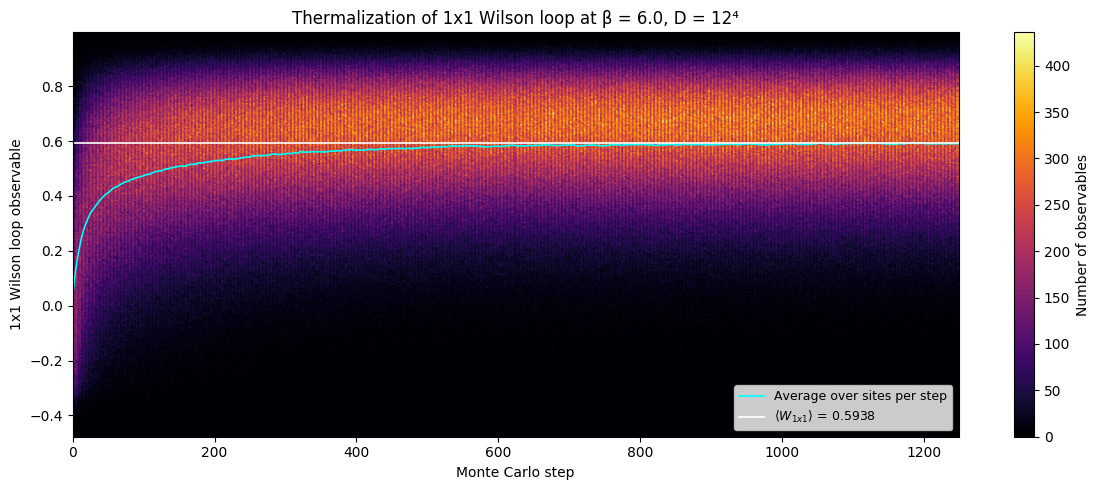

In [4]:
for key in data:
    obs = data[key]
    final_value = 0.593802
    means = np.mean(obs, axis=1)

    plt.figure(figsize=(12, 5))
    rng = np.random.default_rng(42)
    step_ids = rng.integers(0, n_steps, size=n_steps * volume)
    site_ids = rng.integers(0, volume, size=n_steps * volume)
    x_vals = step_ids
    y_vals = obs[step_ids, site_ids]

    hb = plt.hexbin(x_vals, y_vals, gridsize=500, cmap='inferno', rasterized=True)
    cb = plt.colorbar(hb)
    cb.set_label('Number of observables')

    plt.plot(np.arange(n_steps), means, color='cyan', lw=1.2,
             label='Average over sites per step')

    plt.axhline(y=final_value, color='white', linestyle='-', lw=1.2,
                label=fr'$\langle W_{{{key}}} \rangle$ = {final_value:.4f}')

    plt.xlabel('Monte Carlo step')
    plt.ylabel(f'{key} Wilson loop observable')
    plt.title(f'Thermalization of {key} Wilson loop at β = {beta}, D = 12⁴')
    plt.legend(loc='lower right', fontsize=9, fancybox=True)
    plt.tight_layout()
    plt.savefig(f'{key}_thermalization_plot.pdf')
    plt.show()